# Greek Parliament Proceedings

## An assignment for the course `Machine Learning in Practise`.

> Adam Panagiotidis, Student <br />
> 8170096 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> adampanag06@gmail.com

---

The dataset of the analysis contains proceedings of the Greek Parliament, available at <https://zenodo.org/record/2587904>. The dataset is described in Zenodo; you can also read <https://lab.imedd.org/en/parliamentary-minutes-from-1989-until-today/>.


## Goal

The goal of the analysis is to identify the political party of a speaker just by his/her speach. In order to achieve that, we will first clear and explore the data. After that we will train some non-neural network algorithms to learn to classify a speech. Last but not least, we will perform the training using neural network algorithms.

## Before you Run the Notebook

Please have in mind that this notebook includes algorithms and machine learning models that require a lot of RAM and GPU power. Running the whole notebook will take many hours on an average computer and it will erase all the current outputs. So, I suggest you to first read the whole notebook and then rerun it if you like.

Also, you have to download the zip file `Greek_Parliament_Proceedings_1989_2019.csv.zip` from [here](https://zenodo.org/record/2587904#.YC8p-2gzaUk).

## Importing Libraries

In [1]:
import pandas as pd 
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import classification_report

from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## File Paths

So, after you have downloaded the necessary zip file, you must **unzip** it and put it in the right place.

You should put it in a folder named data. For example, if the notebook file is in the relative path `Desktop/all_notebooks/`, the file should be in the relative path `Desktop/all_notebooks/data/`

In [2]:
proceedings_file = 'data/Greek_Parliament_Proceedings_1989_2019.csv'

## Obtaining and Cleaning Data

First, we will get the headers.

In [3]:
headers = pd.read_csv(proceedings_file, nrows=0)
headers = headers.columns.tolist()
headers

['member_name',
 'sitting_date',
 'parliamentary_period',
 'parliamentary_session',
 'parliamentary_sitting',
 'political_party',
 'speaker_info',
 'speech']

Now, we will set the data types to string, except `sitting_date` which is datetime.

In [4]:
data_types = { header: np.str for header in headers }
data_types

{'member_name': str,
 'sitting_date': str,
 'parliamentary_period': str,
 'parliamentary_session': str,
 'parliamentary_sitting': str,
 'political_party': str,
 'speaker_info': str,
 'speech': str}

In [5]:
parse_dates = ['sitting_date']

Let's read the whole data.

In [6]:
proceedings = pd.read_csv(proceedings_file,
                            index_col=False, 
                            names=headers,
                            dtype=data_types,
                            parse_dates=parse_dates,
                            skiprows=1)

print(proceedings.shape)
proceedings.head()

(1194407, 8)


,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ..."
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...


In [7]:
proceedings.speaker_info.value_counts().head(10)

προεδρευων                                      354560
προεδρος                                         58067
βουλευτης/ες                                     47165
υφυπουργος οικονομικων                            7201
υπουργος δικαιοσυνης                              5882
υφυπουργος εθνικης παιδειας και θρησκευματων      4367
υφυπουργος αναπτυξης                              3736
υπουργος γεωργιας                                 3707
υπουργος εσωτερικων                               3370
υφυπουργος γεωργιας                               3361
Name: speaker_info, dtype: int64

We see the most common speaker roles. The top 2 are `προεδρευων` and `προεδρος`. But after going through some of their speeches, I saw that they do not speak about political matters. They are mostly something like coordinators. So, we will remove them because their speeches will not help to identify their political party.

In [8]:
proceedings = proceedings[~(proceedings['speaker_info'].isin(['προεδρευων', 'προεδρος']))]
proceedings.head()

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
10,NaN,1989-07-04,period 5,session 1,sitting 2,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
12,τσοβολας κωνσταντινου δημητριος,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,"Κύριε Πρόεδρε, δεν έχουν μοιραστεί όλα τα ψηφ..."
16,τζαννετακης πετρου τζαννης,1989-07-05,period 5,session 1,sitting 3,νεα δημοκρατια,προεδρος της κυβερνησης και υπουργος των εξωτε...,"~""ΕΦΗΜΕΡΙΣ ΤΗΣ ΚΥΒΕΡΝΗΣΕΩΣ ΤΗΣ ΕΛΛΗΝΙΚΗΣ ΔΗΜΟ..."
18,NaN,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,βουλευτης/ες,Να μας τη διαβάσετε.


In [9]:
proceedings.isna().sum()

member_name               47289
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party             124
speaker_info             543871
speech                        9
dtype: int64

We see that there are many field with NaN values. The goal of our analysis is to to identify the political party of a person and use only his/her speech to do that. So, `political_party` and `speech` columns cannot be NaN.

In [10]:
proceedings = proceedings.dropna(subset={'political_party', 'speech'})

proceedings.isna().sum()

member_name               47165
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party               0
speaker_info             543867
speech                        0
dtype: int64

In [11]:
proceedings.dtypes

member_name                      object
sitting_date             datetime64[ns]
parliamentary_period             object
parliamentary_session            object
parliamentary_sitting            object
political_party                  object
speaker_info                     object
speech                           object
dtype: object

In [12]:
proceedings.political_party.value_counts()

νεα δημοκρατια                                                                     232974
πανελληνιο σοσιαλιστικο κινημα                                                     226942
συνασπισμος ριζοσπαστικης αριστερας                                                 81279
κομμουνιστικο κομμα ελλαδας                                                         61753
βουλη                                                                               45876
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          24440
ανεξαρτητοι (εκτος κομματος)                                                        24259
λαικος ορθοδοξος συναγερμος                                                         17310
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     15402
λαικος συνδεσος - χρυση αυγη                                                        14172
ενωση κεντρωων                                                                       6649
δημοκρατικ

We want to keep only the speeches of political parties, so we will remove the speeches of `βουλη`, which is the parliament's speeches, of `ανεξαρτητοι δημοκρατικοι βουλευτες`, which was a temporary group of politicians from various parties and of `ανεξαρτητοι (εκτος κομματος)`, which represents politicians who do not belong to any party.

<br />

We also see that there are some political parties with very few speeches (less than 6000). The prediction models, that we want to create, will probably have problems identifying these parties. So we will remove them. 

Note: At the beginning we removed parties below 5000 speeches, but due to low preccision and recall for some parties, I decided to remove also parties below 6000 speeches.

In [13]:
# Removing non-political parties
proceedings = proceedings[~(proceedings['political_party'].isin(['βουλη', 'ανεξαρτητοι δημοκρατικοι βουλευτες', 'ανεξαρτητοι (εκτος κομματος)']))]

# Removing parties with very few speeches
proceedings = proceedings[~(proceedings['political_party'].isin(['δημοκρατικη ανανεωση', 'αντιπολιτευση', 'κομμουνιστικο κομμα ελλαδας εσωτερικου',
                                                                 'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)',
                                                                 'λαικη ενοτητα', 'πολιτικη ανοιξη', 'δημοκρατικη αριστερα',
                                                                 'ανεξαρτητοι ελληνες - πανος καμμενος', 'το ποταμι',
                                                                 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια']))]

proceedings.political_party.value_counts()

νεα δημοκρατια                                                                     232974
πανελληνιο σοσιαλιστικο κινημα                                                     226942
συνασπισμος ριζοσπαστικης αριστερας                                                 81279
κομμουνιστικο κομμα ελλαδας                                                         61753
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          24440
λαικος ορθοδοξος συναγερμος                                                         17310
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     15402
λαικος συνδεσος - χρυση αυγη                                                        14172
ενωση κεντρωων                                                                       6649
δημοκρατικο κοινωνικο κινημα                                                         6056
Name: political_party, dtype: int64

## Data Exploration and Visualization

In order to unserstand our dataset better and perform various machine learnings models to it, we will fisrt explore it.


### Speeches per Party
Let's find out how many speeches every party has made and visualize it.

In [15]:
speeches_per_party = pd.DataFrame()

speeches_per_party['speeches_made'] = proceedings.groupby('political_party')['political_party'].count().sort_values(ascending=False)

speeches_per_party = speeches_per_party.reset_index()

speeches_per_party

,political_party,speeches_made
0,νεα δημοκρατια,232974
1,πανελληνιο σοσιαλιστικο κινημα,226942
2,συνασπισμος ριζοσπαστικης αριστερας,81279
3,κομμουνιστικο κομμα ελλαδας,61753
4,συνασπισμος της αριστερας των κινηματων και τη...,24440
5,λαικος ορθοδοξος συναγερμος,17310
6,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,15402
7,λαικος συνδεσος - χρυση αυγη,14172
8,ενωση κεντρωων,6649
9,δημοκρατικο κοινωνικο κινημα,6056


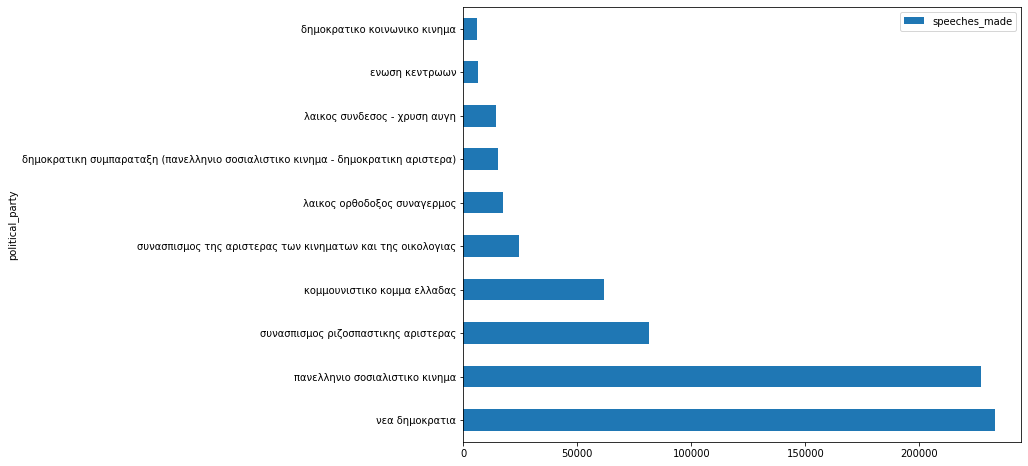

In [16]:
speeches_per_party.plot(x="political_party", y="speeches_made", kind='barh', figsize=(10,8))

We see two parties having the lead and two more after them that have a significant number of speeches.

### Speeches over time

In [17]:
speeches_per_time = pd.DataFrame()

speeches_per_time['month'] = proceedings['sitting_date'].dt.to_period('M')
speeches_per_time['year'] = proceedings['sitting_date'].dt.to_period('Y')
speeches_per_time['party'] = proceedings['political_party']

speeches_per_time.head()

,month,year,party
12,1989-07,1989,πανελληνιο σοσιαλιστικο κινημα
16,1989-07,1989,νεα δημοκρατια
18,1989-07,1989,πανελληνιο σοσιαλιστικο κινημα
21,1989-07,1989,πανελληνιο σοσιαλιστικο κινημα
23,1989-07,1989,πανελληνιο σοσιαλιστικο κινημα


In [18]:
speeches_per_month = pd.DataFrame()

speeches_per_month['scpeeches_count'] = speeches_per_time.groupby('month')['month'].count()

speeches_per_month = speeches_per_month.reset_index()

speeches_per_month

,month,scpeeches_count
0,1989-07,1422
1,1989-09,3337
2,1989-10,1376
3,1989-11,85
4,1989-12,574
...,...,...
319,2018-10,1019
320,2018-11,1314
321,2018-12,2139
322,2019-01,2374


In [19]:
speeches_per_year = pd.DataFrame()

speeches_per_year['scpeeches_count'] = speeches_per_time.groupby('year')['year'].count()

speeches_per_year = speeches_per_year.reset_index()

speeches_per_year.head()

,year,scpeeches_count
0,1989,6794
1,1990,23471
2,1991,30529
3,1992,34194
4,1993,28665


Now, we will see the number of speeches that took place each month for all the availiable years that the dataset has. 

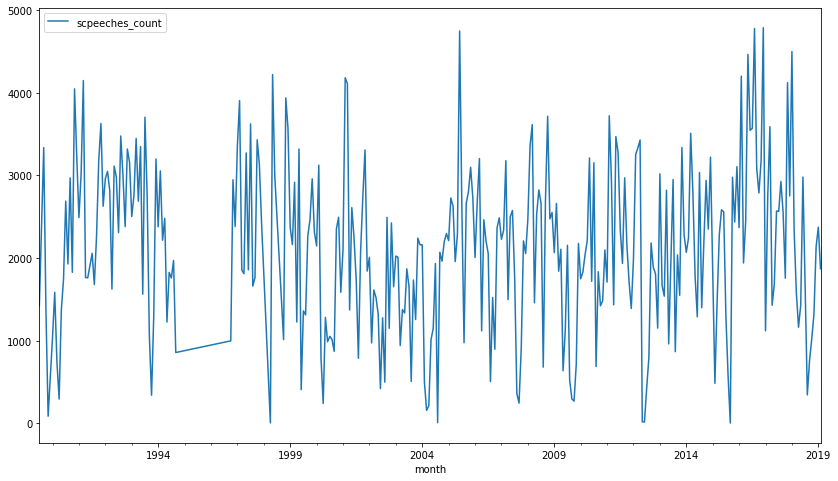

In [20]:
speeches_per_month.plot(x="month", y="scpeeches_count", figsize=(14,8))

We observe a lot of ups and downs which tells us that there are month with very few speeches and months with a lot of speeches.

Here, we will see the same but for every year.

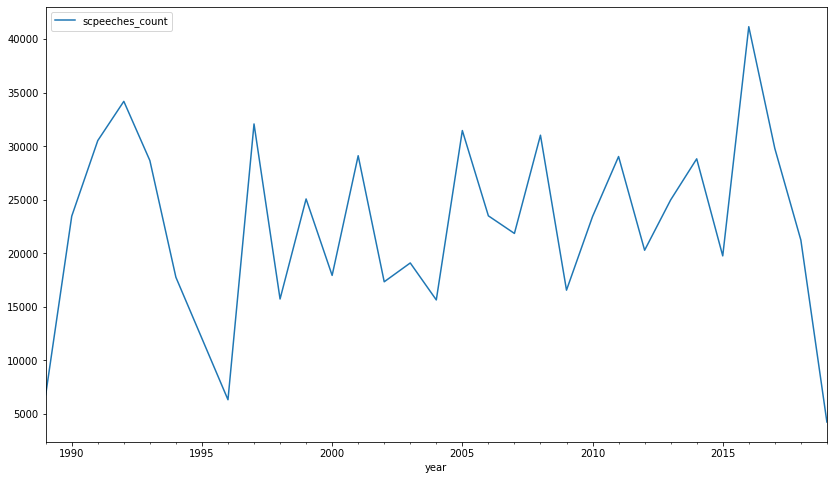

In [21]:
speeches_per_year.plot(x="year", y="scpeeches_count", figsize=(14,8))

It is obvious that 1999 was the year with vary few speechs. Note that 2019 has a few speeches because the data includes only the first months of this year. Also, 2016 was by bar the year with the most speeches and that happened because of the political instability in Greece at that time.

Let's see the numbers in an array also.


In [22]:
speeches_per_year.sort_values(by='scpeeches_count', ascending=False)

,year,scpeeches_count
26,2016,41166
3,1992,34194
7,1997,32083
15,2005,31467
18,2008,31031
2,1991,30529
27,2017,29795
11,2001,29115
21,2011,29040
24,2014,28825


### Speeches per party and time.

In [24]:
speeches_per_year_party = pd.DataFrame()

speeches_per_year_party['scpeeches_count'] = speeches_per_time.groupby(['party', 'year'])['year'].count()

speeches_per_year_party = speeches_per_year_party.reset_index()

speeches_per_year_party.head()

,party,year,scpeeches_count
0,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,2015,359
1,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,2016,7015
2,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,2017,4700
3,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,2018,2907
4,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,2019,421


Here we will see the speeches that each party have made per year.

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


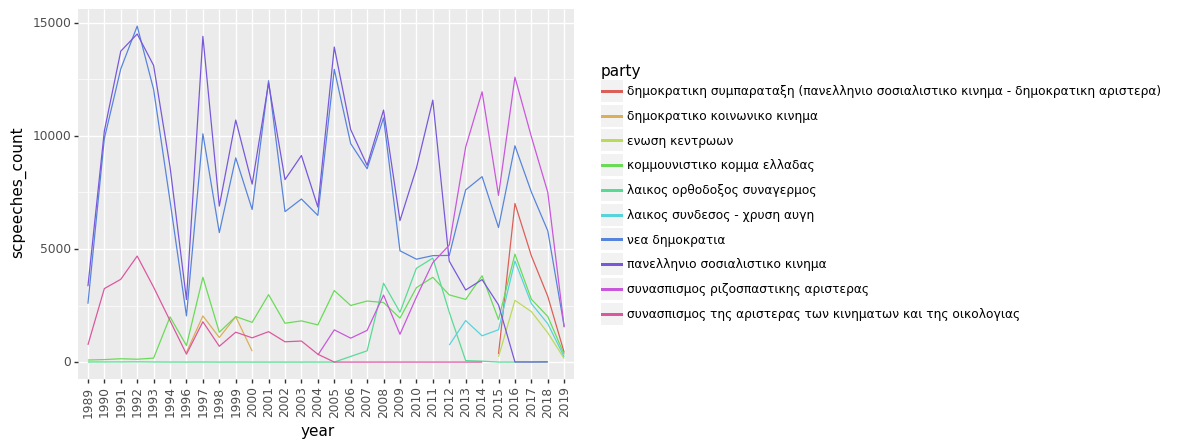

<ggplot: (-9223363264360583971)>

In [25]:
ggplot(data=speeches_per_year_party) + \
    geom_line(aes(x='year', y='scpeeches_count', group='party', colour='party', fill='party')) + \
        theme(axis_text_x=element_text(angle = 90, hjust = 0.8))

Here we see the same but the speeches are summed for every year.

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


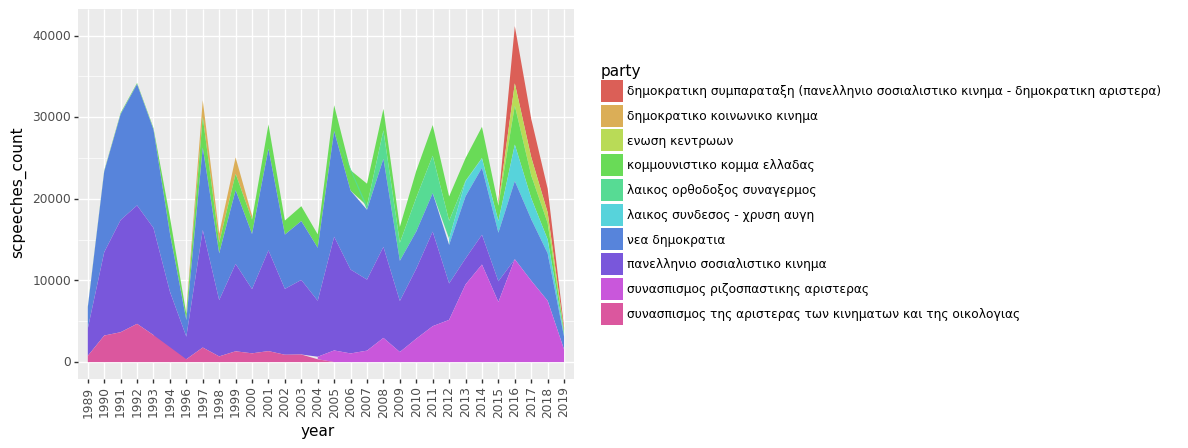

<ggplot: (8772494179122)>

In [26]:
ggplot(data=speeches_per_year_party) + \
    geom_area(aes(x='year', y='scpeeches_count', group='party', fill='party')) + \
        theme(axis_text_x=element_text(angle = 90, hjust = 0.8))

### Speakers per Party

In [27]:
speakers = proceedings[['member_name', 'political_party']].copy()

# Keep only the unique members.
speakers = speakers.drop_duplicates(subset=['member_name'])

speakers_per_party = pd.DataFrame()
speakers_per_party['members_count'] = speakers.groupby('political_party')['member_name'].count()
speakers_per_party = speakers_per_party.sort_values(by='members_count', ascending=False).reset_index()

speakers_per_party

,political_party,members_count
0,νεα δημοκρατια,440
1,πανελληνιο σοσιαλιστικο κινημα,427
2,συνασπισμος ριζοσπαστικης αριστερας,198
3,κομμουνιστικο κομμα ελλαδας,52
4,συνασπισμος της αριστερας των κινηματων και τη...,39
5,λαικος συνδεσος - χρυση αυγη,26
6,λαικος ορθοδοξος συναγερμος,16
7,δημοκρατικο κοινωνικο κινημα,8
8,ενωση κεντρωων,8
9,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,3


Here we see the number of speakers of each party.

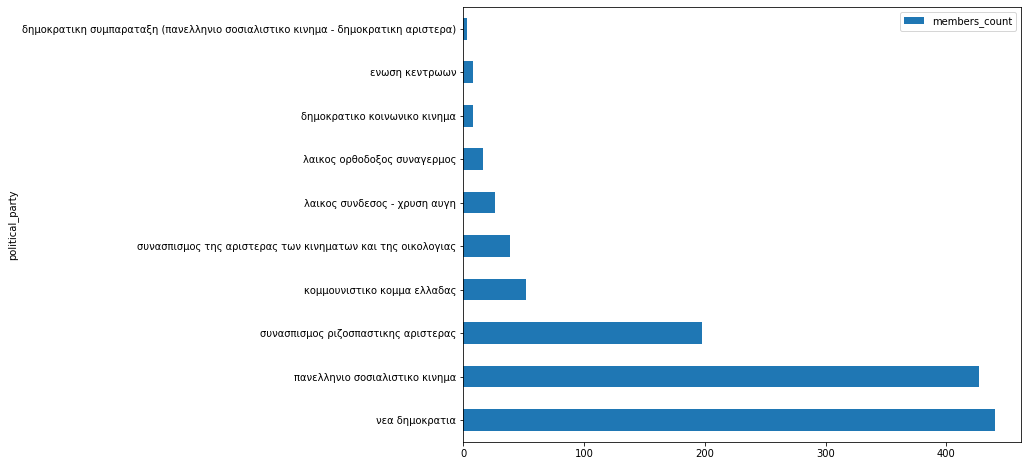

In [28]:
speakers_per_party.plot(x="political_party", y="members_count", kind='barh', figsize=(10,8))

### Top Speakers and their Party

Let's find the top 10 speakers with the most speeches.

In [29]:
speakers = pd.DataFrame()
speakers['speeches_count'] = proceedings.groupby('member_name')['member_name'].count().sort_values(ascending=False)

top_speakers = speakers.head(10).reset_index()

top_speakers

,member_name,speeches_count
0,κακλαμανης χρηστου αποστολος,11269
1,λαφαζανης γεωργιου παναγιωτης,9394
2,παυλοπουλος βασιλειου προκοπιος,8320
3,κορακας χρηστου ευστρατιος,6835
4,λοβερδος νικολαου ανδρεας,6824
5,βενιζελος βασιλειου ευαγγελος,6705
6,ροντουλης γεωργιου αστεριος,5988
7,σιουφας γεωργιου δημητριος,5558
8,γκατζης φιλιππου νικολαος,5489
9,μητσοτακης κυριακου κωνσταντινος,5197


Now, we will get their political party.

In [30]:
top_speakers = top_speakers.merge(proceedings[['political_party', 'member_name']], on='member_name')
top_speakers

,member_name,speeches_count,political_party
0,κακλαμανης χρηστου αποστολος,11269,πανελληνιο σοσιαλιστικο κινημα
1,κακλαμανης χρηστου αποστολος,11269,πανελληνιο σοσιαλιστικο κινημα
2,κακλαμανης χρηστου αποστολος,11269,πανελληνιο σοσιαλιστικο κινημα
3,κακλαμανης χρηστου αποστολος,11269,πανελληνιο σοσιαλιστικο κινημα
4,κακλαμανης χρηστου αποστολος,11269,πανελληνιο σοσιαλιστικο κινημα
...,...,...,...
71574,μητσοτακης κυριακου κωνσταντινος,5197,νεα δημοκρατια
71575,μητσοτακης κυριακου κωνσταντινος,5197,νεα δημοκρατια
71576,μητσοτακης κυριακου κωνσταντινος,5197,νεα δημοκρατια
71577,μητσοτακης κυριακου κωνσταντινος,5197,νεα δημοκρατια


In [31]:
top_speakers = top_speakers.drop_duplicates()
top_speakers

,member_name,speeches_count,political_party
0,κακλαμανης χρηστου αποστολος,11269,πανελληνιο σοσιαλιστικο κινημα
11269,λαφαζανης γεωργιου παναγιωτης,9394,συνασπισμος της αριστερας των κινηματων και τη...
12791,λαφαζανης γεωργιου παναγιωτης,9394,συνασπισμος ριζοσπαστικης αριστερας
20663,παυλοπουλος βασιλειου προκοπιος,8320,νεα δημοκρατια
28983,κορακας χρηστου ευστρατιος,6835,κομμουνιστικο κομμα ελλαδας
29055,κορακας χρηστου ευστρατιος,6835,συνασπισμος της αριστερας των κινηματων και τη...
35818,λοβερδος νικολαου ανδρεας,6824,πανελληνιο σοσιαλιστικο κινημα
39526,λοβερδος νικολαου ανδρεας,6824,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...
42642,βενιζελος βασιλειου ευαγγελος,6705,πανελληνιο σοσιαλιστικο κινημα
49025,βενιζελος βασιλειου ευαγγελος,6705,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...


We see that `λαφαζανης γεωργιου παναγιωτης`, `κορακας χρηστου ευστρατιος`, `βενιζελος βασιλειου ευαγγελος` and `λοβερδος νικολαου ανδρεας` were members of two differnt patries. So we must count the speeches that they made as members of each one of the different parties.

In [32]:
# Count the speeches he made for each party.
laf_saoi = proceedings[(proceedings['member_name'] == 'λαφαζανης γεωργιου παναγιωτης') 
                        & (proceedings['political_party'] == 'συνασπισμος της αριστερας των κινηματων και της οικολογιας')].shape[0]
laf_sr = proceedings[(proceedings['member_name'] == 'λαφαζανης γεωργιου παναγιωτης') & (proceedings['political_party'] == 'συνασπισμος ριζοσπαστικης αριστερας')].shape[0]

kor_kke = proceedings[(proceedings['member_name'] == 'κορακας χρηστου ευστρατιος') & (proceedings['political_party'] == 'κομμουνιστικο κομμα ελλαδας')].shape[0]
kor_saoi = proceedings[(proceedings['member_name'] == 'κορακας χρηστου ευστρατιος') 
                        & (proceedings['political_party'] == 'συνασπισμος της αριστερας των κινηματων και της οικολογιας')].shape[0]

lov_pasok = proceedings[(proceedings['member_name'] == 'λοβερδος νικολαου ανδρεας') & (proceedings['political_party'] == 'πανελληνιο σοσιαλιστικο κινημα')].shape[0]
lov_dimar = proceedings[(proceedings['member_name'] == 'λοβερδος νικολαου ανδρεας') & (proceedings['political_party'] == 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)')].shape[0]

ven_pasok = proceedings[(proceedings['member_name'] == 'βενιζελος βασιλειου ευαγγελος') & (proceedings['political_party'] == 'πανελληνιο σοσιαλιστικο κινημα')].shape[0]
ven_dimar = proceedings[(proceedings['member_name'] == 'βενιζελος βασιλειου ευαγγελος') & (proceedings['political_party'] == 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)')].shape[0]


# Update the values.
top_speakers.loc[(top_speakers['member_name'] == 'λαφαζανης γεωργιου παναγιωτης') 
                & (top_speakers['political_party'] == 'συνασπισμος της αριστερας των κινηματων και της οικολογιας'), 'speeches_count'] = laf_saoi
top_speakers.loc[(top_speakers['member_name'] == 'λαφαζανης γεωργιου παναγιωτης') 
                & (top_speakers['political_party'] == 'συνασπισμος ριζοσπαστικης αριστερας'), 'speeches_count'] = laf_sr

top_speakers.loc[(top_speakers['member_name'] == 'κορακας χρηστου ευστρατιος') 
                & (top_speakers['political_party'] == 'κομμουνιστικο κομμα ελλαδας'), 'speeches_count'] = kor_kke
top_speakers.loc[(top_speakers['member_name'] == 'κορακας χρηστου ευστρατιος') 
                & (top_speakers['political_party'] == 'συνασπισμος της αριστερας των κινηματων και της οικολογιας'), 'speeches_count'] = kor_saoi

top_speakers.loc[(top_speakers['member_name'] == 'λοβερδος νικολαου ανδρεας') 
                & (top_speakers['political_party'] == 'πανελληνιο σοσιαλιστικο κινημα'), 'speeches_count'] = lov_pasok
top_speakers.loc[(top_speakers['member_name'] == 'λοβερδος νικολαου ανδρεας') 
                & (top_speakers['political_party'] == 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)'), 'speeches_count'] = lov_dimar

top_speakers.loc[(top_speakers['member_name'] == 'βενιζελος βασιλειου ευαγγελος') 
                & (top_speakers['political_party'] == 'πανελληνιο σοσιαλιστικο κινημα'), 'speeches_count'] = ven_pasok
top_speakers.loc[(top_speakers['member_name'] == 'βενιζελος βασιλειου ευαγγελος') 
                & (top_speakers['political_party'] == 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)'), 'speeches_count'] = ven_dimar

top_speakers

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,member_name,speeches_count,political_party
0,κακλαμανης χρηστου αποστολος,11269,πανελληνιο σοσιαλιστικο κινημα
11269,λαφαζανης γεωργιου παναγιωτης,1522,συνασπισμος της αριστερας των κινηματων και τη...
12791,λαφαζανης γεωργιου παναγιωτης,7872,συνασπισμος ριζοσπαστικης αριστερας
20663,παυλοπουλος βασιλειου προκοπιος,8320,νεα δημοκρατια
28983,κορακας χρηστου ευστρατιος,3871,κομμουνιστικο κομμα ελλαδας
29055,κορακας χρηστου ευστρατιος,2964,συνασπισμος της αριστερας των κινηματων και τη...
35818,λοβερδος νικολαου ανδρεας,3708,πανελληνιο σοσιαλιστικο κινημα
39526,λοβερδος νικολαου ανδρεας,3116,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...
42642,βενιζελος βασιλειου ευαγγελος,6383,πανελληνιο σοσιαλιστικο κινημα
49025,βενιζελος βασιλειου ευαγγελος,322,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...


Here we see the 10 politicians with the most speeches made and the party that they belonged to when they made the speeches.

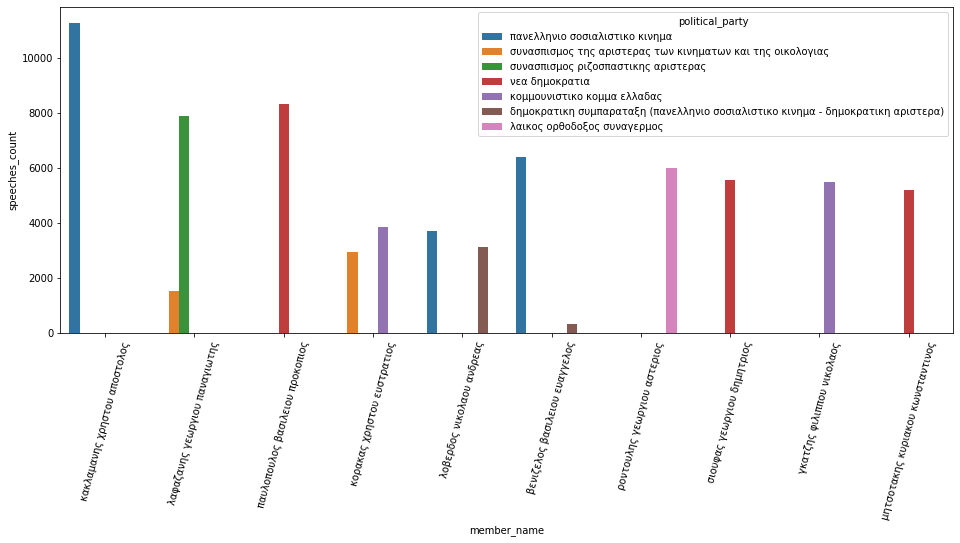

In [33]:
plt.figure(figsize=(16, 6))
sns.barplot(x="member_name", y="speeches_count", hue="political_party", data=top_speakers)
plt.xticks(rotation=75)
plt.show()

## Split Data to Training and Testing

Let's create a new dataframe and put there only the data tha we need for our models.

In [14]:
text = pd.DataFrame()
text[['data', 'target']] = proceedings[[ 'speech', 'political_party']].copy()
text

,data,target
12,"Κύριε Πρόεδρε, δεν έχουν μοιραστεί όλα τα ψηφ...",πανελληνιο σοσιαλιστικο κινημα
16,"~""ΕΦΗΜΕΡΙΣ ΤΗΣ ΚΥΒΕΡΝΗΣΕΩΣ ΤΗΣ ΕΛΛΗΝΙΚΗΣ ΔΗΜΟ...",νεα δημοκρατια
18,Να μας τη διαβάσετε.,πανελληνιο σοσιαλιστικο κινημα
21,"Κύριε Πρόεδρε, κατ' αρχή θα πω μερικές κουβέν...",πανελληνιο σοσιαλιστικο κινημα
23,Λέει ο Κανονισμός ότι σε εξαιρετικές περιπτώσ...,πανελληνιο σοσιαλιστικο κινημα
...,...,...
1194392,"Μα, τι λέτε τώρα;",νεα δημοκρατια
1194393,Καταλαβαίνετε τι λέτε τώρα; Αυτό είναι το πρώ...,συνασπισμος ριζοσπαστικης αριστερας
1194395,"Ευχαριστώ, κύριε Πρόεδρε.Κύριε Υπουργέ, έγινα...",κομμουνιστικο κομμα ελλαδας
1194397,"Ολοκλήρωσα, κύριε Πρόεδρε. Αντιλαμβάνεστε ότι...",κομμουνιστικο κομμα ελλαδας


In [15]:
data = text.data
target = text.target
target_names = sorted(text.target.unique().tolist())

We split the data to 70% training and 30% testing.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state = 42)

## Classification without Neural Networks

Now we are ready to start training a model that predicts the political party, using classification algorithms. But first we will create a preprocessing method that transforms all letters to lower cases and removes digits. We will use this method for all of our algorithms.

In [17]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

For every classification algorithm that we will use next, we will create a pipline with:
  - CountVectorizer: which converts a collection of text documents to a matrix of token counts.
  - TfidfTransformer: which transforms a count matrix to a normalized term-frequency or term-frequency times inverse document-frequency representation.

### Multinomial Naive Bayes

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer(preprocessor=preprocess_text)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

Score: 0.44373926460741214



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.00      0.00      0.00      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.00      0.00      0.00      1834
                                                                 ενωση κεντρωων       0.00      0.00      0.00      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.42      0.32      0.36     18726
                                                    λαικος ορθοδοξος συναγερμος       0.50      0.00      0.00      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.00      0.00      0.00      4179
                                                                 νεα δημοκρατια       0.44      0.65      0.52     69911
                               

We achieved an accuracy of 44,4%. Let's put `ngram_range=(1, 2)` in our CountVectorizer, in order to take in account not only single words, but groups of two words also.




In [ ]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), preprocessor=preprocess_text)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

Score: 0.44568012654419825



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.00      0.00      0.00      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.00      0.00      0.00      1834
                                                                 ενωση κεντρωων       0.00      0.00      0.00      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.42      0.31      0.36     18726
                                                    λαικος ορθοδοξος συναγερμος       0.00      0.00      0.00      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.00      0.00      0.00      4179
                                                                 νεα δημοκρατια       0.45      0.60      0.51     69911
                               

After the addition to the CountVextorizer the accuracy went to 44,7%. A bit higher than without the `ngram_range=(1, 2)`. So, we will continue with that. The only problem is that it consumes a lot more RAM and it takes longer time.

<br />

Apart from that, we will try more classification algorithms in order to achieve a better accuracy.

### Stohastic Gradient Descend

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2), preprocessor=preprocess_text)),
                      ('tfidf', TfidfTransformer()),
                      ('sgd', SGDClassifier())])

sgd.fit(X_train, y_train)

predicted = sgd.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

Score: 0.49639484895241975

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.24      0.10      0.14      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.37      0.03      0.06      1834
                                                                 ενωση κεντρωων       0.56      0.05      0.09      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.47      0.58      0.52     18726
                                                    λαικος ορθοδοξος συναγερμος       0.51      0.13      0.21      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.42      0.38      0.40      4179
                                                                 νεα δημοκρατια       0.50      0.63      0.56     69911
   

With the Stohastic Gradient Descend algorithm we achieved 49,6% accuracy. More than 5% higher than our previous score. Let's try some more algorithms.

### Logistic Regression

I tried to run the Logistic Regression with `ngram_range=(1, 2)` as parameter in Count Vectorizer, but it consumed all the availiable RAM of my computer and of google colab. So, we will perform the Logistic Regression without it.

In [ ]:
from sklearn.linear_model import LogisticRegression

logR = Pipeline(steps=[('vect', CountVectorizer(preprocessor=preprocess_text)),
                     ('tfidf', TfidfTransformer()),
                     ('logR', LogisticRegression(n_jobs=1, C=1e5))])

logR.fit(X_train, y_train)

predicted = logR.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score: 0.4878987258241385

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.29      0.03      0.06      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.52      0.02      0.03      1834
                                                                 ενωση κεντρωων       0.88      0.01      0.02      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.47      0.55      0.51     18726
                                                    λαικος ορθοδοξος συναγερμος       0.53      0.16      0.24      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.41      0.33      0.36      4179
                                                                 νεα δημοκρατια       0.50      0.57      0.53     69911
    

We have achieved 48.8% accuracy.

### AdaBoost Classifier

In [38]:
from sklearn.ensemble import AdaBoostClassifier
ada = Pipeline(steps=[('vect', CountVectorizer(preprocessor=preprocess_text)),
                      ('tfidf', TfidfTransformer()),
                      ('ada', AdaBoostClassifier(n_estimators=100))])

ada.fit(X_train, y_train)

predicted = ada.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

Score: 0.3966248410919289
                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.41      0.04      0.07      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.14      0.08      0.10      1834
                                                                 ενωση κεντρωων       0.45      0.08      0.13      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.45      0.40      0.42     18726
                                                    λαικος ορθοδοξος συναγερμος       0.49      0.10      0.16      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.42      0.33      0.37      4179
                                                                 νεα δημοκρατια       0.39      0.57      0.46     69911
     

We achieved an accuracy of 39.7% which is not so good comparing it with the previous results.

### XGBoost Classifier

In [18]:
import xgboost as xgb

xgboost = Pipeline(steps=[('vect', CountVectorizer(preprocessor=preprocess_text)),
                          ('tfidf', TfidfTransformer()),
                          ('xgboost', xgb.XGBClassifier())])

xgboost.fit(X_train, y_train)

predicted = xgboost.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

Score: 0.43211350160606327
                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.77      0.03      0.05      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.78      0.07      0.12      1834
                                                                 ενωση κεντρωων       0.76      0.08      0.14      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.52      0.38      0.44     18726
                                                    λαικος ορθοδοξος συναγερμος       0.86      0.09      0.16      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.43      0.34      0.38      4179
                                                                 νεα δημοκρατια       0.42      0.71      0.52     69911
    

We have achieved an accuracy of 43.2% which is not the best one.

### Other Classifiers

I also tried `Random Forest Classifier`, but after 8 hours it didn't finish running.

### Dummy Classifier

Let's run a dummy classifier in order to compare it with our previous solutions and see if our previous classifiers achieve a better accruracy than a classifier that uses only simple rules.

In [ ]:
from sklearn.dummy import DummyClassifier

dc = Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer()),
                      ('dc', DummyClassifier())])

dc.fit(X_train, y_train)

predicted = dc.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Score: 0.2442896095642267
                                                                                 precision    recall  f1-score   support

                                                 πανελληνιο σοσιαλιστικο κινημα       0.03      0.03      0.03      9088
                                                                 νεα δημοκρατια       0.01      0.01      0.01      4187
                                                    κομμουνιστικο κομμα ελλαδας       0.00      0.00      0.00      1603
                     συνασπισμος της αριστερας των κινηματων και της οικολογιας       0.02      0.02      0.02      6875
                                                    λαικος ορθοδοξος συναγερμος       0.01      0.01      0.01      1822
                                                   ανεξαρτητοι (εκτος κομματος)       0.01      0.01      0.01      2935
                                                   δημοκρατικο κοινωνικο κινημα       0.07      0.07      0.07     23465
     

As we can see, we achieved an accuracy of 24,5% which is half of the accuracy that we got from Stohastic Gradient Descend or Logistic Regression. So we are doing a good job.

### Grid Search

It is time to run a grid search for the best performing algorithms so far, in order to find the best hyperparameters. <br/>

The most promising ones are `Stohastic Gradient Descend` and `Logistic Regression`, so let's run grid search for these two.

#### Stohastic Gradient Descend with Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])

parameters = {
  'clf__alpha': (1e-4, 1e-5, 1e-6),
  'clf__penalty': ('l2', 'l1'),
  'clf__max_iter': (700, 1000, 1300),
  'clf__tol': (1e-2, 1e-3, 1e-4),
}

gs_sgd = GridSearchCV(pipeline, parameters, n_jobs=-1)

gs_sgd.fit(X_train, y_train)

best_params = gs_sgd.best_estimator_.get_params()
print('Best parameters:')
for param_name in parameters.keys():
    print("\t%s: %r" % (param_name, best_params[param_name]))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters:
	clf__alpha: 1e-06
	clf__penalty: 'l2'
	clf__max_iter: 1300
	clf__tol: 0.0001


So, as we can see we got some results, but `penalty` has the same value as the default value of SGDClassifier. Let's train another SGDClassifier with `alpha = 1e-06`, `max_iter = 1300` and `tol=0.0001`.



In [ ]:
 from sklearn.linear_model import SGDClassifier

sgd = Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2), preprocessor=preprocess_text)),
                      ('tfidf', TfidfTransformer()),
                      ('sgd', SGDClassifier(alpha=1e-06, 
                                            max_iter=1300,
                                            tol=0.0001))])

sgd.fit(X_train, y_train)

predicted = sgd.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

Score: 0.5220676002212583

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.48      0.13      0.20      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.67      0.18      0.28      1834
                                                                 ενωση κεντρωων       0.80      0.10      0.18      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.52      0.54      0.53     18726
                                                    λαικος ορθοδοξος συναγερμος       0.29      0.29      0.29      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.70      0.20      0.31      4179
                                                                 νεα δημοκρατια       0.54      0.60      0.57     69911
    

We achieved an accuracy of 52.2% which is the highest so far!

#### Logistic Regression with Grid Search

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())])

parameters = {
  'clf__C': (1.0, 100.0, 1e5),
  'clf__max_iter': (100, 200, 300),
}

gs_logR = GridSearchCV(pipeline, parameters, n_jobs=-1)

gs_logR.fit(X_train, y_train)

best_params = gs_logR.best_estimator_.get_params()
print('Best parameters:')
for param_name in parameters.keys():
    print("\t%s: %r" % (param_name, best_params[param_name]))
"""

Running the above grid search, even with only two parameters, consumed all the vailiable RAM. So, I will try another Ligistic Regression with a value other than 100, which is the default, at `max_iter`. Let's go with 250.

In [ ]:
from sklearn.linear_model import LogisticRegression

logR = Pipeline(steps=[('vect', CountVectorizer(preprocessor=preprocess_text)),
                     ('tfidf', TfidfTransformer()),
                     ('logR', LogisticRegression(n_jobs=1, C=1e5, max_iter=250))])

logR.fit(X_train, y_train)

predicted = logR.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score: 0.5094956670257261

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.54      0.08      0.15      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.68      0.13      0.22      1834
                                                                 ενωση κεντρωων       0.76      0.07      0.13      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.49      0.55      0.52     18726
                                                    λαικος ορθοδοξος συναγερμος       0.69      0.21      0.32      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.43      0.35      0.39      4179
                                                                 νεα δημοκρατια       0.50      0.62      0.56     69911
    

We see that the accuracy of the original Logistic Regression improved. Let's thry with a higher `max_iter` at 500. 

In [ ]:
from sklearn.linear_model import LogisticRegression

logR = Pipeline(steps=[('vect', CountVectorizer(preprocessor=preprocess_text)),
                     ('tfidf', TfidfTransformer()),
                     ('logR', LogisticRegression(n_jobs=1, C=1e5, max_iter=500))])

logR.fit(X_train, y_train)

predicted = logR.predict(X_test)
print('Score:', np.mean(predicted == y_test), end='\n\n')

print(classification_report(y_test, predicted,
                                    target_names=target_names))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score: 0.5043475307384009

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.41      0.12      0.19      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.50      0.20      0.29      1834
                                                                 ενωση κεντρωων       0.64      0.10      0.18      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.47      0.57      0.52     18726
                                                    λαικος ορθοδοξος συναγερμος       0.57      0.25      0.35      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.42      0.39      0.41      4179
                                                                 νεα δημοκρατια       0.52      0.55      0.54     69911
    

As we can see we achieved an accuracy of 50.4% which is worse than the previous Logistic Regression that we have ran. So, the best model that we have trained so far is the one with the Stohastic Gradient Descend Classifier that we ran after the grid search.

### Best Prediction Model - Stohastic Gradient Decend

In [ ]:
# Copied and pasted the cell of the classification report of the best performing model.
#
# If you have reran the notebook, the output of this cell will be empty. So, if that happened,
# you can see the report of you go to the "Strohastic Gradient Descent with Grid Search" section.

Score: 0.5220676002212583

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.48      0.13      0.20      4747
                                                   δημοκρατικο κοινωνικο κινημα       0.67      0.18      0.28      1834
                                                                 ενωση κεντρωων       0.80      0.10      0.18      1983
                                                    κομμουνιστικο κομμα ελλαδας       0.52      0.54      0.53     18726
                                                    λαικος ορθοδοξος συναγερμος       0.29      0.29      0.29      5083
                                                   λαικος συνδεσος - χρυση αυγη       0.70      0.20      0.31      4179
                                                                 νεα δημοκρατια       0.54      0.60      0.57     69911
    

As you can see, the **highest accuracy** that we achieved is **52.2%**. Also, even for the political parties with low support we achieved a satisfying recall and f1-score.

## Classification with Neural Networks

Now let's train a model that predicts the political party of the speaker, using neural networks.

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Prepare Data
To begin with, we will use `Tokenizer` of TensorFlow in order to convert each text(speech) into a sequence of integers.

Source of how to use Tokenizer: [towards data science](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17)

In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 400
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(proceedings.speech.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 560516 unique tokens.


Now, let's transform the list of sequences into a 2D array.

In [16]:
data = tokenizer.texts_to_sequences(proceedings.speech.values)
data = pad_sequences(data, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (686977, 400)


We will greate dummies for every label.

In [17]:
labels = pd.get_dummies(proceedings.political_party).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (686977, 10)


It's time to split the data into 70% training and 30% testing.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state = 42)

In [19]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(480883, 400) (480883, 10)
(206094, 400) (206094, 10)


### Start TPU

Source of how to start TPU: [colab](https://colab.research.google.com/notebooks/tpu.ipynb?fbclid=IwAR0Pb_v5RNi_sWzZZetOEgy-EZ4kBOcLHObE1kRdc-YfQbQQNMP_gKW_4L8#scrollTo=FpvUOuC3j27n)

In [20]:
# If you want to ran the models with TPU, uncomment the bellow code.

"""
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
"""

'\n%tensorflow_version 2.x\nimport tensorflow as tf\nprint("Tensorflow version " + tf.__version__)\n\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

### Create first 3 Models

Now, we will create some models, trying different layers. In general, since we want to do multi-class text classification, a good choice would be `categorical crossentropy` as our loss funnction, `softmax` as activation function in the last layer and `adam` as the optimizer. But, we will try some more functions in order to be sure that these are the best choices. 

In [21]:
def create_model():

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=(data.shape[1],), activation='softmax')
  ])

  sgd = optimizers.SGD(learning_rate=0.1)
  
  model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
  return model

def create_model_2():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
  model.add(keras.layers.SpatialDropout1D(0.2))
  model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))
  sgd = optimizers.SGD(learning_rate=0.1)
  model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

  return model

def create_model_3():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
  model.add(keras.layers.SpatialDropout1D(0.2))
  model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Creating the model in the TPUStrategy scope means we will train the model on the TPU
#
# If you want to ran the models with TPU, uncomment the bellow code
# and nest the models inside the "with tpu_strategy.scope()".

# with tpu_strategy.scope():
model = create_model()
model_2 = create_model_2()
model_3 = create_model_3()

print(model.summary())
print(model_2.summary())
print(model_3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                4010      
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          10000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 10,081,410
Tr

### Dense

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/5
7514/7514 [==============================] - 117s 15ms/step - loss: 14051199.3736 - accuracy: 0.2582
Epoch 2/5
7514/7514 [==============================] - 116s 15ms/step - loss: 14255505.4466 - accuracy: 0.2593
Epoch 3/5
7514/7514 [==============================] - 114s 15ms/step - loss: 14375589.2283 - accuracy: 0.2600
Epoch 4/5
7514/7514 [==============================] - 115s 15ms/step - loss: 14294425.6745 - accuracy: 0.2574
Epoch 5/5
7514/7514 [==============================] - 116s 15ms/step - loss: 14389311.6846 - accuracy: 0.2577


We do not expect this model to improve its accuracy, I did it for learning reasons.

### Embedding - LSTM - mean_squared_error

This neural network consists of an Embedding, a SpatialDropout1D, an LSTM and a Dense layer.

In [ ]:
epochs = 5
batch_size = 64

history = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
6763/6763 [==============================] - 362s 53ms/step - loss: 0.0781 - accuracy: 0.3309 - val_loss: 0.0745 - val_accuracy: 0.3451
Epoch 2/5
6763/6763 [==============================] - 355s 52ms/step - loss: 0.0744 - accuracy: 0.3437 - val_loss: 0.0742 - val_accuracy: 0.3369
Epoch 3/5
6763/6763 [==============================] - 354s 52ms/step - loss: 0.0741 - accuracy: 0.3422 - val_loss: 0.0739 - val_accuracy: 0.3359
Epoch 4/5
6763/6763 [==============================] - 354s 52ms/step - loss: 0.0739 - accuracy: 0.3487 - val_loss: 0.0737 - val_accuracy: 0.3602
Epoch 5/5
6763/6763 [==============================] - 354s 52ms/step - loss: 0.0736 - accuracy: 0.3596 - val_loss: 0.0734 - val_accuracy: 0.3548


We achieved 35.5% accuracy which is not so good. Probably because we put `mean squared error` as the loss function and `SGD` as our optimizer.

### Embedding - LSTM - categorical_crossentropy

This model has the same layers as the one before. The difference is on the loss function and on the optimizer.

In [ ]:
epochs = 20
batch_size = 64

history = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
6763/6763 [==============================] - 310s 45ms/step - loss: 1.5512 - accuracy: 0.3770 - val_loss: 1.3612 - val_accuracy: 0.4510
Epoch 2/20
6763/6763 [==============================] - 298s 44ms/step - loss: 1.2945 - accuracy: 0.4910 - val_loss: 1.2626 - val_accuracy: 0.5021
Epoch 3/20
6763/6763 [==============================] - 299s 44ms/step - loss: 1.1311 - accuracy: 0.5653 - val_loss: 1.2722 - val_accuracy: 0.5061
Epoch 4/20
6763/6763 [==============================] - 298s 44ms/step - loss: 1.0234 - accuracy: 0.6058 - val_loss: 1.3212 - val_accuracy: 0.4991
Epoch 5/20
6763/6763 [==============================] - 299s 44ms/step - loss: 0.9451 - accuracy: 0.6358 - val_loss: 1.3683 - val_accuracy: 0.4976


In [ ]:
accr = model_3.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6441/6441 [==============================] - 132s 20ms/step - loss: 1.3709 - accuracy: 0.4969
Test set
  Loss: 1.371
  Accuracy: 0.497


We see that with the same layers as before, but with `categorical crossentrophy`, `softmax` and `adam`, we achieve an accuracy of 49.7%.

### Embedding - Flatten

This neural network consists of an Embedding, a Flatten and two Dense layers.

In [25]:
def create_model_fl():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Creating the model in the TPUStrategy scope means we will train the model on the TPU
#
# If you want to ran the models with TPU, uncomment the bellow code
# and nest the models inside the "with tpu_strategy.scope()".

# with tpu_strategy.scope():
model_fl = create_model_fl()

print(model_fl.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 100)          10000000  
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4000100   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 14,001,110
Trainable params: 14,001,110
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 20
batch_size = 32

history_fl = model_fl.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.0001)])

Epoch 1/20
13525/13525 [==============================] - 330s 24ms/step - loss: 1.4596 - accuracy: 0.4094 - val_loss: 1.3111 - val_accuracy: 0.4809
Epoch 2/20
13525/13525 [==============================] - 324s 24ms/step - loss: 1.0699 - accuracy: 0.5807 - val_loss: 1.4359 - val_accuracy: 0.4680
Epoch 3/20
13525/13525 [==============================] - 327s 24ms/step - loss: 0.8235 - accuracy: 0.6852 - val_loss: 1.8677 - val_accuracy: 0.4506
Epoch 4/20
13525/13525 [==============================] - 325s 24ms/step - loss: 0.7007 - accuracy: 0.7357 - val_loss: 2.2204 - val_accuracy: 0.4446
Epoch 5/20
13525/13525 [==============================] - 326s 24ms/step - loss: 0.6327 - accuracy: 0.7621 - val_loss: 2.5125 - val_accuracy: 0.4419


As you can se it stopped because we put patience=4 in EasrlyStopping. Even from the second epoch the validation accuracy is decreasing, whareas the training accuracy is increasing, which means that the model has overfitted.

### Embedding - GlobalMaxPooling1D

This neural network consists of an Embedding, a GlobalMaxPooling1D and two Dense layers

In [26]:
def create_model_gmp():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
  model.add(keras.layers.GlobalMaxPooling1D())
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Creating the model in the TPUStrategy scope means we will train the model on the TPU
#
# If you want to ran the models with TPU, uncomment the bellow code
# and nest the models inside the "with tpu_strategy.scope()".

# with tpu_strategy.scope():
model_gmp = create_model_gmp()

print(model_gmp.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 100)          10000000  
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 10,011,110
Trainable params: 10,011,110
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 20
batch_size = 32

history_5 = model_gmp.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.0001)])

Epoch 1/20
13525/13525 [==============================] - 311s 23ms/step - loss: 1.4849 - accuracy: 0.4045 - val_loss: 1.3458 - val_accuracy: 0.4622
Epoch 2/20
13525/13525 [==============================] - 307s 23ms/step - loss: 1.3035 - accuracy: 0.4870 - val_loss: 1.3194 - val_accuracy: 0.4740
Epoch 3/20
13525/13525 [==============================] - 305s 23ms/step - loss: 1.2292 - accuracy: 0.5270 - val_loss: 1.3093 - val_accuracy: 0.4851
Epoch 4/20
13525/13525 [==============================] - 304s 22ms/step - loss: 1.1672 - accuracy: 0.5555 - val_loss: 1.3260 - val_accuracy: 0.4840
Epoch 5/20
13525/13525 [==============================] - 303s 22ms/step - loss: 1.1136 - accuracy: 0.5785 - val_loss: 1.3524 - val_accuracy: 0.4872
Epoch 6/20
13525/13525 [==============================] - 305s 23ms/step - loss: 1.0679 - accuracy: 0.5976 - val_loss: 1.3636 - val_accuracy: 0.4841
Epoch 7/20
13525/13525 [==============================] - 304s 22ms/step - loss: 1.0235 - accuracy: 0.6179

Colab stopped it due to time limit, but as we see the validation accuracy is getting worse, so there is no point to re-run it. It reached almost 49% validation accuracy, but validation loss in also increasing, so this model also became overfitted.

### CNN

Let's try a Convolutional Neural Network (CNN). The neural network will be cinsisted an Embedding, a Conv1D (which is the convolutional layer), a GlobalMaxPooling1D and two Dense layers.

The idea of the model was from [Nikolai Janakiev - realpython.com](https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn)

However, we will choose softmax as the activation method for our model because it is more suitable for multi-class text classification.

In [28]:
def create_model_cnn():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
  model.add(keras.layers.Conv1D(128, 5, activation='relu'))
  model.add(keras.layers.GlobalMaxPooling1D())
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Creating the model in the TPUStrategy scope means we will train the model on the TPU
#
# If you want to ran the models with TPU, uncomment the bellow code
# and nest the models inside the "with tpu_strategy.scope()".

# with tpu_strategy.scope():
model_cnn = create_model_cnn()

print(model_cnn.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 100)          10000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 128)          64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 10,078,038
Trainable params: 10,078,038
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
epochs = 20
batch_size = 32

history_cnn = model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001)])

Epoch 1/20
13525/13525 [==============================] - 323s 23ms/step - loss: 1.4317 - accuracy: 0.4297 - val_loss: 1.2795 - val_accuracy: 0.4941
Epoch 2/20
13525/13525 [==============================] - 317s 23ms/step - loss: 1.1718 - accuracy: 0.5440 - val_loss: 1.2681 - val_accuracy: 0.5050
Epoch 3/20
13525/13525 [==============================] - 317s 23ms/step - loss: 0.9969 - accuracy: 0.6190 - val_loss: 1.3403 - val_accuracy: 0.4928
Epoch 4/20
13525/13525 [==============================] - 316s 23ms/step - loss: 0.8429 - accuracy: 0.6809 - val_loss: 1.5163 - val_accuracy: 0.4845
Epoch 5/20
13525/13525 [==============================] - 315s 23ms/step - loss: 0.7398 - accuracy: 0.7218 - val_loss: 1.7220 - val_accuracy: 0.4829
Epoch 6/20
13525/13525 [==============================] - 317s 23ms/step - loss: 0.6749 - accuracy: 0.7468 - val_loss: 1.9396 - val_accuracy: 0.4667
Epoch 7/20
13525/13525 [==============================] - 317s 23ms/step - loss: 0.6253 - accuracy: 0.7659

In [23]:
accr = model_cnn.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6441/6441 [==============================] - 101s 16ms/step - loss: 2.1579 - accuracy: 0.4610
Test set
  Loss: 2.158
  Accuracy: 0.461


We ended up with a 46.1% accuracy and the training stopped because we put patience=5 in EarlyStopping. Althoug the trained started very well, with 49.4% accuracy, but after epoch 2 it became overffited. Let's have a better look by visualizing the loss and the accuracy of the training and testing data.

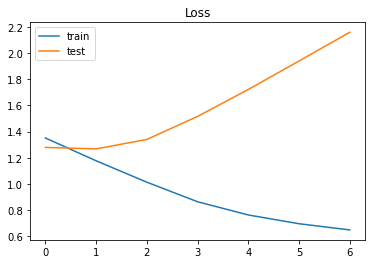

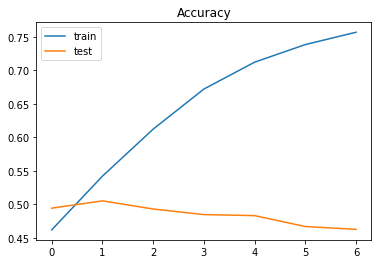

In [28]:
plt.title('Loss')
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='test')
plt.legend()
plt.show()

print("\n\n")

plt.title('Accuracy')
plt.plot(history_cnn.history['accuracy'], label='train')
plt.plot(history_cnn.history['val_accuracy'], label='test')
plt.legend()
plt.show();

It is obvious that after the second epoch the model becomes overfitted.

### Second CCN

Let's try the same model again but with `softmax`, instead of `relu`, as the activation function in the penultimate Dense layer.

In [29]:
def create_model_cnn_2():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
  model.add(keras.layers.Conv1D(128, 5, activation='relu'))
  model.add(keras.layers.GlobalMaxPooling1D())
  model.add(keras.layers.Dense(100, activation='softmax'))
  model.add(keras.layers.Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Creating the model in the TPUStrategy scope means we will train the model on the TPU
#
# If you want to ran the models with TPU, uncomment the bellow code
# and nest the models inside the "with tpu_strategy.scope()".

# with tpu_strategy.scope():
model_cnn_2 = create_model_cnn_2()

print(model_cnn_2.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 400, 100)          10000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 396, 128)          64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1010      
Total params: 10,078,038
Trainable params: 10,078,038
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 20
batch_size = 32

history_cnn_2 = model_cnn_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001)])

Epoch 1/20
13525/13525 [==============================] - 330s 24ms/step - loss: 1.6554 - accuracy: 0.3508 - val_loss: 1.5774 - val_accuracy: 0.3633
Epoch 2/20
13525/13525 [==============================] - 325s 24ms/step - loss: 1.5741 - accuracy: 0.3656 - val_loss: 1.5768 - val_accuracy: 0.3633
Epoch 3/20
13525/13525 [==============================] - 324s 24ms/step - loss: 1.5782 - accuracy: 0.3626 - val_loss: 1.5706 - val_accuracy: 0.3686
Epoch 4/20
13525/13525 [==============================] - 324s 24ms/step - loss: 1.5462 - accuracy: 0.3814 - val_loss: 1.4859 - val_accuracy: 0.3939
Epoch 5/20
13525/13525 [==============================] - 322s 24ms/step - loss: 1.4455 - accuracy: 0.4139 - val_loss: 1.4490 - val_accuracy: 0.4240
Epoch 6/20
13525/13525 [==============================] - 319s 24ms/step - loss: 1.3469 - accuracy: 0.4800 - val_loss: 1.4086 - val_accuracy: 0.4542
Epoch 7/20
13525/13525 [==============================] - 320s 24ms/step - loss: 1.1984 - accuracy: 0.5648

In [ ]:
accr = model_cnn_2.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6441/6441 [==============================] - 109s 17ms/step - loss: 1.8544 - accuracy: 0.4442
Test set
  Loss: 1.854
  Accuracy: 0.444


Now, we see that the validation accuracy may starts at 36.3% but it is improving. However, at 46% it becomes overfitted again. Eventually it ends up at 44.4%.

### Third CNN

The last CNN look very promising at the beginning of the training. Let's keep it the same and only change the output units of the penultimate `Dense` layer, from 100 to 64.

In [30]:
def create_model_cnn_3():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
  model.add(keras.layers.Conv1D(128, 5, activation='relu'))
  model.add(keras.layers.GlobalMaxPooling1D())
  model.add(keras.layers.Dense(64, activation='softmax'))
  model.add(keras.layers.Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Creating the model in the TPUStrategy scope means we will train the model on the TPU
#
# If you want to ran the models with TPU, uncomment the bellow code
# and nest the models inside the "with tpu_strategy.scope()".

# with tpu_strategy.scope():
model_cnn_3 = create_model_cnn_3()

print(model_cnn_3.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 400, 100)          10000000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 396, 128)          64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 10,073,034
Trainable params: 10,073,034
Non-trainable params: 0
_________________________________________________________________
None


We will also set the `batch size` to 64, instead of 32.

In [32]:
epochs = 20
batch_size = 64

history_cnn_3 = model_cnn_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001)])

Epoch 1/20
6763/6763 [==============================] - 170s 24ms/step - loss: 1.7412 - accuracy: 0.3323 - val_loss: 1.5842 - val_accuracy: 0.3634
Epoch 2/20
6763/6763 [==============================] - 161s 24ms/step - loss: 1.5769 - accuracy: 0.3667 - val_loss: 1.5718 - val_accuracy: 0.3655
Epoch 3/20
6763/6763 [==============================] - 160s 24ms/step - loss: 1.5666 - accuracy: 0.3673 - val_loss: 1.5695 - val_accuracy: 0.3640
Epoch 4/20
6763/6763 [==============================] - 163s 24ms/step - loss: 1.5290 - accuracy: 0.3792 - val_loss: 1.4823 - val_accuracy: 0.3898
Epoch 5/20
6763/6763 [==============================] - 161s 24ms/step - loss: 1.4375 - accuracy: 0.4058 - val_loss: 1.4495 - val_accuracy: 0.3989
Epoch 6/20
6763/6763 [==============================] - 162s 24ms/step - loss: 1.3528 - accuracy: 0.4393 - val_loss: 1.4436 - val_accuracy: 0.4164
Epoch 7/20
6763/6763 [==============================] - 163s 24ms/step - loss: 1.2519 - accuracy: 0.5059 - val_loss: 1

In [33]:
accr = model_cnn_3.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6441/6441 [==============================] - 101s 16ms/step - loss: 2.3309 - accuracy: 0.4302
Test set
  Loss: 2.331
  Accuracy: 0.430


The result is the same as before, but now it started to overfit at 43.7% accuracy, even less than before.

### Best Performing Model

The best performing model so far was the one with an Embedding, a SpatialDropout1D, an LSTM and a Dense layer. The activation function was `softmax`, the loss function was `categorical crossentrophy` and the optimizer was `adam`.



In [31]:
# Creating the model in the TPUStrategy scope means we will train the model on the TPU
#
# If you want to ran the models with TPU, uncomment the bellow code
# and nest the models inside the "with tpu_strategy.scope()".

# with tpu_strategy.scope():
model_3 = create_model_3()

Let's re-train the best performing model with a batch size of 32 instead of 64 and increase the patience of EarlyStopping to 5, instead of 3.

In [ ]:
epochs = 20
batch_size = 32

history_3 = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001)])

Epoch 1/20
13525/13525 [==============================] - 583s 42ms/step - loss: 1.5227 - accuracy: 0.3846 - val_loss: 1.3154 - val_accuracy: 0.4767
Epoch 2/20
13525/13525 [==============================] - 572s 42ms/step - loss: 1.2446 - accuracy: 0.5134 - val_loss: 1.2476 - val_accuracy: 0.5087
Epoch 3/20
13525/13525 [==============================] - 572s 42ms/step - loss: 1.1044 - accuracy: 0.5747 - val_loss: 1.2575 - val_accuracy: 0.5118
Epoch 4/20
13525/13525 [==============================] - 572s 42ms/step - loss: 1.0086 - accuracy: 0.6115 - val_loss: 1.3081 - val_accuracy: 0.5090
Epoch 5/20
13525/13525 [==============================] - 572s 42ms/step - loss: 0.9394 - accuracy: 0.6398 - val_loss: 1.3733 - val_accuracy: 0.5027
Epoch 6/20
13525/13525 [==============================] - 573s 42ms/step - loss: 0.8859 - accuracy: 0.6612 - val_loss: 1.4468 - val_accuracy: 0.4970
Epoch 7/20
13525/13525 [==============================] - 572s 42ms/step - loss: 0.8470 - accuracy: 0.6753

The training stopped due to time limit of colab, but as we can see the validation accuracy is dropping. So, there is no point to re-train it. Also, the validation accuracy will not end up above 49.7% which was the previous best score. 

Something that we can do is to decrease the patience of EarlyStopping in order not to allow the model to overfit and decrease its accuracy.



In [29]:
epochs = 20
batch_size = 32

history_3 = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1, min_delta=0.0001)])

Epoch 1/20
13525/13525 [==============================] - 581s 42ms/step - loss: 1.5081 - accuracy: 0.3902 - val_loss: 1.2980 - val_accuracy: 0.4855
Epoch 2/20
13525/13525 [==============================] - 571s 42ms/step - loss: 1.2303 - accuracy: 0.5205 - val_loss: 1.2487 - val_accuracy: 0.5072
Epoch 3/20
13525/13525 [==============================] - 571s 42ms/step - loss: 1.0949 - accuracy: 0.5767 - val_loss: 1.2634 - val_accuracy: 0.5091
Epoch 4/20
13525/13525 [==============================] - 571s 42ms/step - loss: 1.0017 - accuracy: 0.6148 - val_loss: 1.3133 - val_accuracy: 0.5072


In [30]:
accr = model_3.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6441/6441 [==============================] - 130s 20ms/step - loss: 1.3121 - accuracy: 0.5052
Test set
  Loss: 1.312
  Accuracy: 0.505


Let's print again the summary of the best performing model.

In [22]:
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 100)          10000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 10,081,410
Trainable params: 10,081,410
Non-trainable params: 0
_________________________________________________________________
None


**Accuracy: 50.5%**

### Conclusion

We used a variety of different models and layers, but every time the models becamse overfitted very early. Maybe, at the data preparation section we should set the MAX_SEQUENCE_LENGTH to something lower than 400. Another possible explanation is that each speech is very unique and this makes the training models to learn the training data in detail, which impacts negatively the performance of the models on the testing data.